In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:86% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:130px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:15px;}
</style>
"""))

# 데이터 체크 및 전처리

In [2]:
import pandas as pd
import numpy as np
import joblib
from datetime import datetime, timedelta
import holidays
import matplotlib.pyplot as plt
plt.rc('font',family = 'Hancom Gothic')

# 데이터 로딩 및 전처리
df = pd.read_csv('LSTM최종데이터_X_Y_라벨링등전.csv')
df = df.dropna(subset=['대여량']) # 혹시 모를 결측치 제거 코드 _ 결측치 사전 체크 : 결과 0건

df['일시'] = pd.to_datetime(df['일시'])
df['연'] = df['일시'].dt.year
df['월'] = df['일시'].dt.month
df['일'] = df['일시'].dt.day
df['시'] = df['일시'].dt.hour
df['요일'] = df['일시'].dt.dayofweek
start_year = df['연'].min()
end_year = df['연'].max()
kr_holidays = holidays.KR(years=range(start_year, end_year+1)) # 한국 공휴일 체크 라이브러리
df['공휴일'] = df['일시'].dt.floor('D').isin(kr_holidays).astype(int)

df['key'] = df['행정구'] + '_' + df['월'].astype(str) + '_' + df['일'].astype(str) + '_' + df['시'].astype(str)
df['일시_1년전'] = df['일시'] - pd.DateOffset(years=1)
df['key_1년전'] = df['행정구'] + '_' + df['일시_1년전'].dt.month.astype(str) + '_' + df['일시_1년전'].dt.day.astype(str) + '_' + df['일시_1년전'].dt.hour.astype(str)
cols_to_copy = ['대여량', '총생활인구수']
df_1y = df[cols_to_copy].copy()
df_1y.columns = [c + '_1년전' for c in cols_to_copy]
df = pd.concat((df,df_1y), axis=1)
df = df.dropna(subset=['대여량_1년전', '총생활인구수_1년전'])

df

,연도,월,일,시,행정구,일시,대여량,총생활인구수,계절,출퇴근시간,...,습도,풍속,연,요일,공휴일,key,일시_1년전,key_1년전,대여량_1년전,총생활인구수_1년전
0,2021,1,1,0,강남구,2021-01-01 00:00:00,9.0,618455.4297,겨울,기타,...,59.0,1.4,2021,4,1,강남구_1_1_0,2020-01-01 00:00:00,강남구_1_1_0,9.0,618455.4297
1,2021,1,1,0,강동구,2021-01-01 00:00:00,12.0,525220.6638,겨울,기타,...,60.0,1.4,2021,4,1,강동구_1_1_0,2020-01-01 00:00:00,강동구_1_1_0,12.0,525220.6638
2,2021,1,1,0,강북구,2021-01-01 00:00:00,12.0,321499.2460,겨울,기타,...,54.0,1.1,2021,4,1,강북구_1_1_0,2020-01-01 00:00:00,강북구_1_1_0,12.0,321499.2460
3,2021,1,1,0,강서구,2021-01-01 00:00:00,27.0,547287.6699,겨울,기타,...,52.0,0.9,2021,4,1,강서구_1_1_0,2020-01-01 00:00:00,강서구_1_1_0,27.0,547287.6699
4,2021,1,1,0,관악구,2021-01-01 00:00:00,19.0,492742.3420,겨울,기타,...,50.0,0.9,2021,4,1,관악구_1_1_0,2020-01-01 00:00:00,관악구_1_1_0,19.0,492742.3420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872088,2024,12,31,23,용산구,2024-12-31 23:00:00,37.0,253261.4373,겨울,기타,...,62.0,0.7,2024,1,0,용산구_12_31_23,2023-12-31 23:00:00,용산구_12_31_23,37.0,253261.4373
872089,2024,12,31,23,은평구,2024-12-31 23:00:00,35.0,453205.9782,겨울,기타,...,62.0,1.3,2024,1,0,은평구_12_31_23,2023-12-31 23:00:00,은평구_12_31_23,35.0,453205.9782
872090,2024,12,31,23,종로구,2024-12-31 23:00:00,81.0,231161.5069,겨울,기타,...,68.0,1.7,2024,1,0,종로구_12_31_23,2023-12-31 23:00:00,종로구_12_31_23,81.0,231161.5069
872091,2024,12,31,23,중구,2024-12-31 23:00:00,77.0,172509.0426,겨울,기타,...,68.0,1.7,2024,1,0,중구_12_31_23,2023-12-31 23:00:00,중구_12_31_23,77.0,172509.0426


In [3]:
# 범주형 구간 자동(9개) 생성 (qcut 사용)
num_bins = 9
df['대여량_class'], bins = pd.qcut(df['대여량'], q=num_bins, labels=False, retbins=True, duplicates='drop')
print("대여량 구간 경계값:", bins)

대여량 구간 경계값: [1.000e+00 1.900e+01 3.700e+01 6.200e+01 9.300e+01 1.310e+02 1.800e+02
 2.540e+02 3.930e+02 3.258e+03]


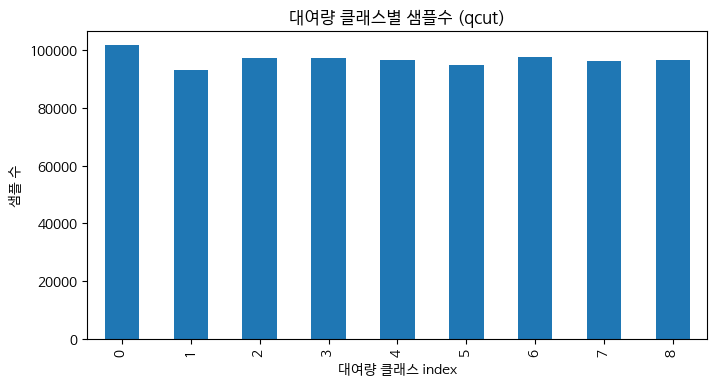

In [4]:
# qcut 이후 데이터 쏠림 현상 체크
plt.figure(figsize=(8,4))
df['대여량_class'].value_counts(sort=False).plot(kind='bar')
plt.title('대여량 클래스별 샘플수 (qcut)')
plt.xlabel('대여량 클래스 index')
plt.ylabel('샘플 수')
plt.show()

In [5]:
# 데이터 전처리 _ 라벨링 및 스케일링
from sklearn.preprocessing import LabelEncoder, StandardScaler
pd.options.mode.copy_on_write = True 
le = LabelEncoder()
df['행정구'] = le.fit_transform(df['행정구'])

feature_cols = [
    '행정구', '월', '일', '시', '요일', '강수', '기온', '습도', '풍속',
    '주말구분', '공휴일',
    '대여량_1년전', '총생활인구수_1년전',
]
X = df[feature_cols]
y = df['대여량_class']

num_cols = [ '강수', '기온', '습도', '풍속',
    '대여량_1년전', '총생활인구수_1년전',]
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

In [6]:
X.shape, y.shape

((872093, 13), (872093,))

In [7]:
# 데이터 분할 : 22년 학습, 23년 검증, 24년 테스트 활용
train_idx = df['연'] == 2022
val_idx = (df['연'] == 2023)
test_idx = (df['연'] == 2024)
X_train, X_val, X_test = X[train_idx], X[val_idx], X[test_idx]
y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]

# 모델 설계 : LightGBM
- Microsoft가 개발한 Gradient Boosting Tree 기반의 알고리즘
- 범주형 변수, 결측치 처리에 강함
- 빠른 속도와 높은 성능
- 시계열 구조는 직접 반영되지 않지만, lag feature 활용으로 보완 가능

In [8]:
# LightGBM 모델
import lightgbm as lgb

num_classes = y.nunique()
lgbm = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=num_classes,
    random_state=42,
    n_estimators=300,
    learning_rate=0.1
)

# 콜백 생성
callbacks = [
    lgb.early_stopping(stopping_rounds=20, first_metric_only=True, verbose=True),
    lgb.log_evaluation(20)  # 20에폭마다 로그
]

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=callbacks
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1217
[LightGBM] [Info] Number of data points in the train set: 217520, number of used features: 13
[LightGBM] [Info] Start training from score -2.160220
[LightGBM] [Info] Start training from score -2.271267
[LightGBM] [Info] Start training from score -2.195484
[LightGBM] [Info] Start training from score -2.209333
[LightGBM] [Info] Start training from score -2.220366
[LightGBM] [Info] Start training from score -2.206907
[LightGBM] [Info] Start training from score -2.153900
[LightGBM] [Info] Start training from score -2.182231
[LightGBM] [Info] Start training from score -2.180276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

LGBMClassifier(n_estimators=300, num_class=9, objective='multiclass',
               random_state=42)

# 모델 평가

Test Accuracy: 0.9919
Test Classification Report
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     17234
           1      1.000     1.000     1.000     22556
           2      1.000     1.000     1.000     25254
           3      0.986     0.985     0.985     25205
           4      0.985     0.986     0.985     25151
           5      0.995     0.986     0.991     24106
           6      0.983     0.987     0.985     25259
           7      0.984     0.993     0.988     25507
           8      0.997     0.994     0.995     28642

    accuracy                          0.992    218914
   macro avg      0.992     0.992     0.992    218914
weighted avg      0.992     0.992     0.992    218914



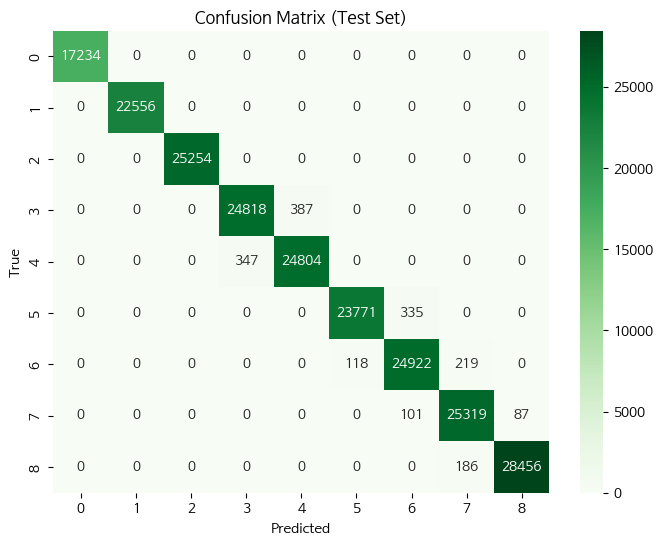

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# 테스트셋
y_pred_test = lgbm.predict(X_test)
test_acc = (y_pred_test == y_test.values).mean()
print(f"Test Accuracy: {test_acc:.4f}")
print("Test Classification Report")
print(classification_report(y_test, y_pred_test, digits=3))
plt.figure(figsize=(8,6))
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 모델 및 각종 필요도구 저장

In [10]:
# 모델, 스케일러, 인코더, feature 리스트 저장
joblib.dump(lgbm, 'best_lgbm_model.pkl')
joblib.dump(scaler, 'ENCODER_SCALER/scaler.pkl')
joblib.dump(le, 'ENCODER_SCALER/labelencoders.pkl')
joblib.dump(feature_cols, 'ENCODER_SCALER//featurecols.pkl')
joblib.dump(num_cols, 'ENCODER_SCALER/numcols.pkl')

['ENCODER_SCALER/numcols.pkl']

# 모델의 사용

In [11]:
def DBMS_find_1year_ago_of_tomorrow():
    """
    오늘 기준으로 '내일'의 1년 전(같은 시각) 데이터를 DB에서 조회하는 함수
    """
    import pymysql
    from dotenv import load_dotenv
    import os
    import pandas as pd
    from datetime import datetime, timedelta

    load_dotenv()
    host = os.getenv('host')
    user = os.getenv('user')
    password = os.getenv('password')
    database = os.getenv('database')
    port = int(os.getenv('port', 3306))

    # 현재 시각
    now = datetime.now()

    # 내일 같은 시각
    tomorrow = now + timedelta(days=1)

    # 1년 전 내일 같은 시각
    dt_1y = tomorrow.replace(year=tomorrow.year - 1)

    # DB 컬럼명에 맞게 쿼리 작성 (연, 월, 일, 시)
    query =f"""
        SELECT *
        FROM basic_data
        WHERE year = {dt_1y.year}
          AND month = {dt_1y.month}
          AND day = {dt_1y.day}
          AND hour = {dt_1y.hour}"""

    try:
        connection = pymysql.connect(
            host=host,
            user=user,
            password=password,
            database=database,
            port=port,
            charset='utf8mb4',
            cursorclass=pymysql.cursors.DictCursor
        )
        with connection.cursor() as cursor:
            cursor.execute(query)
            data = cursor.fetchall()
            result_df = pd.DataFrame(data)
#             print(result_df)
            return result_df
    except Exception as e:
        print('에러 발생:', e)
        return None
    finally:
        try:
            connection.close()
        except:
            pass

# 사용법
DBMS_find_1year_ago_of_tomorrow()

,year,month,day,hour,district,datetime,total_population,season,commute_time,weekend_flag,precipitation,temperature,humidity,wind_speed,rental_count
0,2024,6,29,16,강남구,2024-06-29 16:00:00,842081,여름,기타,1,8.0,23.8,97.0,2.9,311
1,2024,6,29,16,강동구,2024-06-29 16:00:00,475455,여름,기타,1,10.5,23.8,95.0,2.7,336
2,2024,6,29,16,강북구,2024-06-29 16:00:00,257030,여름,기타,1,3.5,23.8,96.0,1.6,143
3,2024,6,29,16,강서구,2024-06-29 16:00:00,516196,여름,기타,1,3.5,24.0,94.0,3.4,1013
4,2024,6,29,16,관악구,2024-06-29 16:00:00,420214,여름,기타,1,8.5,23.5,94.0,1.8,210
5,2024,6,29,16,광진구,2024-06-29 16:00:00,355876,여름,기타,1,8.0,23.8,97.0,2.9,428
6,2024,6,29,16,구로구,2024-06-29 16:00:00,367624,여름,기타,1,5.0,24.4,94.0,3.1,329
7,2024,6,29,16,금천구,2024-06-29 16:00:00,192274,여름,기타,1,5.0,24.4,94.0,3.1,93
8,2024,6,29,16,노원구,2024-06-29 16:00:00,452627,여름,기타,1,3.5,23.8,96.0,1.6,613
9,2024,6,29,16,도봉구,2024-06-29 16:00:00,247246,여름,기타,1,3.5,23.8,96.0,1.6,228


In [12]:
# 클래스 index → 대여량 구간 변환 함수
def class_to_range(pred_class):
    global bins
    pred_class = int(pred_class)
    left = int(bins[pred_class])
    right = int(bins[pred_class+1]) if pred_class+1 < len(bins) else '+'
    return f"{left} ~ {right}"

# 예측 함수 (LightGBM 버전)
def predict_bike_demand(행정구, 강수, 습도, 풍속, 기온):
    """
    행정구명, 강수, 습도, 풍속, 기온을 입력받아
    해당 시간의 공공자전거 대여량 예측 클래스를 반환하는 함수 (LightGBM)
    """
    import pandas as pd
    import numpy as np
    import joblib
    from datetime import datetime, timedelta
    import holidays
    
    le = joblib.load('ENCODER_SCALER/labelencoders.pkl')
    scaler = joblib.load('ENCODER_SCALER/scaler.pkl')
    feature_cols = joblib.load('ENCODER_SCALER/featurecols.pkl')
    num_cols = joblib.load('ENCODER_SCALER/numcols.pkl')
    model = joblib.load('best_lgbm_model.pkl')

    now = datetime.now()
    년, 월, 일, 시 = now.year, now.month, now.day, now.hour
    요일 = now.weekday()
    주말구분 = 1 if 요일 >= 5 else 0
    kr_holidays = holidays.KR(years=[년])
    공휴일 = int(now.date() in kr_holidays)

    df_1y = DBMS_find_1year_ago_of_tomorrow()
    대여량_1년전 = df_1y[df_1y['district']==행정구].loc[:,'rental_count']
    총생활인구수_1년전 = df_1y[df_1y['district']==행정구].loc[:,'total_population']

    input_dict = {
        '행정구': le.transform([행정구])[0],
        '월': 월,
        '일': 일,
        '시': 시,
        '요일': 요일,
        '강수': 강수,
        '기온': 기온,
        '습도': 습도,
        '풍속': 풍속,
        '주말구분': 주말구분,
        '공휴일': 공휴일,
        '대여량_1년전': 대여량_1년전,
        '총생활인구수_1년전': 총생활인구수_1년전,
    }
    input_df = pd.DataFrame([input_dict])
    input_df[num_cols] = scaler.transform(input_df[num_cols])
    X_input = input_df[feature_cols].values
    pred_class = int(model.predict(X_input)[0])
    return pred_class

In [13]:
# 사용 예시
pred = predict_bike_demand('강남구', 0.2, 60, 2.5, 21)
print(pred, class_to_range(pred))

7 254 ~ 393
